**Amenity Recognition**


**main**

Random photo of an AirBnB listing in Madrid:


/tmp/ipython-input-2521581514.py:48: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  jpg_mask = urls.str.contains(r"\.(jpe?g)(?=$|\?)", case=False, regex=True)


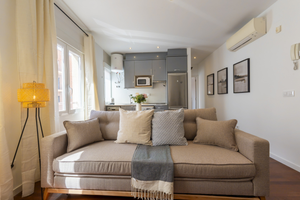

✅ Displayed 300x300 image from:
https://a0.muscache.com/pictures/prohost-api/Hosting-1394909045968155316/original/36e96147-493a-4fdb-9439-b85584c18bfd.jpeg
Top 30 Ameneties in Airbnb Madrid  listings:
Top amenities (amenity, count):
- wifi router, 25127
- kitchen, 23416
- tv, 21729
- washer, 21576
- hot water, 19583
- heating, 19017
- air conditioning unit, 19008
- dryer, 18384
- hangers, 18033
- ironing board, 17551
COCO labels detection using YOLOv8:


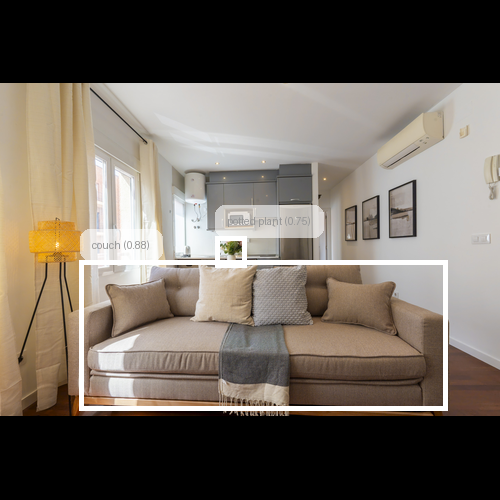

Detections (label, confidence):
 - couch: 0.88
 - potted plant: 0.75
OVD Detection of top N ameneties in AirBnB:


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/613M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cpu


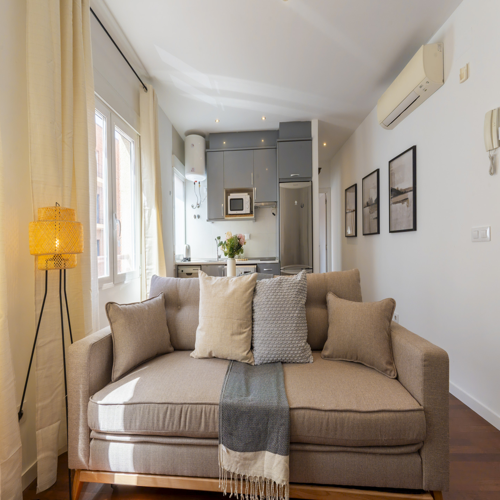

In [ ]:

# !pip install ultralytics pillow requests
print("Random photo of an AirBnB listing in Madrid:")
random_jpg_url = show_random_jpg_from_inside_airbnb("https://data.insideairbnb.com/spain/comunidad-de-madrid/madrid/2025-06-12/data/listings.csv.gz")
print("Top 30 Ameneties in Airbnb Madrid  listings:")
ameneties_list = top_visual_amenities_from_inside_airbnb_csv(top_n=10)
# print("ameneties_list:", ameneties_list)
print("COCO labels detection using YOLOv8:")
image_detected= detect_coco_labels_clear(random_jpg_url)
print("OVD Detection of top N ameneties in AirBnB:")
detections = detect_amenities_ovd(random_jpg_url, ameneties_list, score_threshold=0.15, visualize=True)
# print(detections)

**Function 1 - top amenities from airbnb DB - normalized**

input: "inside airbnb" CSV, amount of ameneties needed (int)

output: Airbnb top N household Ameneties by hosts normalized

This function cleans manually entered amenity data, converting free-form text into a standardized list of tangible,**observable** amenities.
ameneties for example: “oven,” “air conditioning,”, "TV".

it also combine similiar ameneties: “TV/television/42-inch HDTV” --> "tv".

It also filters out invalid or non-physical entries provided by hosts, such as rules or descriptions like “lake view,” “free parking,” or other irrelevant phrases.

of course this isn't bullet-proof because it is relys on free text entered  by users.

We only take TopN features which have thousands of repetitions among hosts so those are the most common ameneties.  

Behavior change (per request):
- Prints: a sorted list of (amenity, count) for the top-N.
- Returns: a list of amenity strings ONLY (lowercase), sorted from most to least common.

Parameters
----------

csv_path : str, default points to madrid's AirBnb listing open source DB "https://data.insideairbnb.com/spain/comunidad-de-madrid/madrid/2025-06-12/data/listings.csv.gz"

top_n : int, default=90 Number of amenities to consider for printing/returning.

amenities_column : str, default="amenities" Column name containing stringified lists of amenities that AirBnB gave.






In [ ]:
# @title
import ast
import re
from collections import Counter
from typing import Iterable, List, Tuple

import pandas as pd


def top_visual_amenities_from_inside_airbnb_csv(
    csv_path: str = "https://data.insideairbnb.com/spain/comunidad-de-madrid/madrid/2025-06-12/data/listings.csv.gz",
    top_n: int = 90,
    amenities_column: str = "amenities",
) -> List[str]:
    """
    Compute the top-N most common *photo-recognizable* amenities from an Inside Airbnb listings CSV.

    Behavior change (per request):
      - Prints: a sorted list of (amenity, count) for the top-N.
      - Returns: a list of amenity strings ONLY (lowercase), sorted from most to least common.

    Parameters
    ----------
    csv_path : str, default points to the Inside Airbnb Greater Manchester (2025-06-24) CSV (gzipped).
    top_n : int, default=90
        Number of amenities to consider for printing/returning.
    amenities_column : str, default="amenities"
        Column name containing stringified lists of amenities.

    Notes about Inside Airbnb CSVs
    ------------------------------
    - The 'amenities' field typically looks like a Python list in string form:
      '["Wifi", "TV", "Kitchen", "Washer", "Paid parking off premises", "Host will be present"]'
    - We parse it with ast.literal_eval safely.
    """

    # ---------- 1) Load only the amenities column ----------
    df = pd.read_csv(csv_path, usecols=[amenities_column])

    # ---------- 2) Helpers: cleaning & classification rules ----------

    # (a) Words/phrases that indicate *rules/services/conditions* (non-amenities).
    NON_AMENITY_PATTERNS: Iterable[re.Pattern] = [
        re.compile(r"\b(host|hostess)\b.*\b(present|greets|greeter)\b", re.I),
        re.compile(r"\b(luggage|baggage)\b.*\b(drop[- ]?off|storage|allowed)\b", re.I),
        re.compile(r"\b(pets?|animals?)\b.*\b(allowed|not allowed|no)\b", re.I),
        re.compile(r"\b(long[- ]?term|extended)\b.*\b(stays?)\b", re.I),
        re.compile(r"\b(events?|parties?)\b.*\b(allowed|permitted|no|not allowed)\b", re.I),
        re.compile(r"\b(smoking)\b.*\b(allowed|permitted|no|not allowed)\b", re.I),
        re.compile(r"\b(breakfast|meals?|meal plan|room service)\b", re.I),
        re.compile(r"\b(daily|weekly|monthly)\b.*\b(cleaning|housekeeping)\b", re.I),
        re.compile(r"\b(check[- ]?in)\b.*\b(assistance|time|anytime)\b", re.I),

        # child-safety guards / covers
        re.compile(r"\btable\s+corner\s+guards?\b", re.I),
        re.compile(r"\boutlet\s+covers?\b", re.I),
        re.compile(r"\bwindow\s+guards?\b", re.I),

        # services / recommendations / access
        re.compile(r"\bbabysitter\s+recommendations?\b", re.I),
        re.compile(r"\bresort\s+access\b", re.I),
        re.compile(r"\bbuilding\s+staff\b", re.I),
        re.compile(r"\bski[-\s]?in\s*/\s*ski[-\s]?out\b", re.I),
        re.compile(r"\bski[-\s]?in\s+ski[-\s]?out\b", re.I),

        # generic “X view” location attributes
        re.compile(r"\b[a-z][\w\s-]*\s+view\b", re.I),

        # location attribute
        re.compile(r"\bwaterfront\b", re.I),

        # access / entry, not a tangible amenity
        re.compile(r"\bkeypad\b", re.I),
        re.compile(r"\bself[-\s]?check[-\s]?in\b", re.I),

        # property/structure descriptors
        re.compile(r"\bsingle[-\s]level\s+home\b", re.I),

        # kitchen odds & ends / catch-alls
        re.compile(r"\bbaking\s+sheet\b", re.I),
        re.compile(r"\bessentials\b", re.I),
        re.compile(r"\bcooking\s+basics\b", re.I),

        # playground outside the unit
        re.compile(r"\boutdoor\s+playground\b", re.I),
    ]

    # (b) Normalization: remove qualifiers we cannot trust from photos
    QUALIFIER_CLEANUPS: Iterable[re.Pattern] = [
        re.compile(r"\b(free|paid|complimentary|extra fee|fee|24/7|twenty[- ]four[- ]seven)\b", re.I),
        re.compile(r"\b(on[- ]?premises|off[- ]?premises|on[- ]?site|off[- ]?site|nearby|street|public|private|shared)\b", re.I),
        re.compile(r"\b(in[- ]?building|in the building|in unit|on floor|ground floor|rooftop)\b", re.I),
    ]

    # (c) Simple negative statements to *exclude* outright
    NEGATIVE_PATTERNS: Iterable[re.Pattern] = [
        re.compile(r"\b(no|not|without)\s+parking\b", re.I),
    ]

    # (d) Mapping from many raw variants -> a single, visual amenity label.
    NORMALIZATION_RULES: List[Tuple[re.Pattern, str]] = [
        # Media & living
        (re.compile(r"\b(smart\s*tv|television|tv)\b", re.I), "TV"),
        (re.compile(r"\b(projector)\b", re.I), "projector"),
        (re.compile(r"\b(sound\s*system|speakers?)\b", re.I), "sound system"),
        (re.compile(
            r"\b(?:"                       # game consoles (collapse to "game console")
            r"game\s*console(?:\s*:\s*\w+)?|"
            r"playstation(?:\s*\d+)?|ps[1-5]|"
            r"xbox(?:\s*(?:one|360|series\s*(?:x|s))?)|"
            r"nintendo\s*switch|wii(?:\s*u)?|gamecube"
            r")\b", re.I
        ), "game console"),

        # Kitchen core
        (re.compile(r"\b(kitchen)\b", re.I), "Kitchen"),
        (re.compile(r"\b(refrigerator|fridge)\b", re.I), "refrigerator"),
        (re.compile(r"\b(dishwasher)\b", re.I), "dishwasher"),
        (re.compile(r"\b(oven)\b", re.I), "oven"),
        (re.compile(r"\b(stove|cooktop|range)\b", re.I), "stove"),
        (re.compile(r"\b(microwave)\b", re.I), "microwave"),
        (re.compile(r"\b(coffee\s*maker|espresso|nespresso|keurig)\b", re.I), "coffee maker"),
        (re.compile(r"\b(kettle|electric\s*kettle)\b", re.I), "kettle"),
        (re.compile(r"\b(toaster)\b", re.I), "toaster"),

        # Laundry
        (re.compile(r"\b(washer|washing\s*machine)\b", re.I), "washer"),
        (re.compile(r"\b(dryer|tumble\s*dryer)\b", re.I), "dryer"),
        (re.compile(r"\b(iron|ironing\s*board)\b", re.I), "ironing board"),

        # Climate & safety
        (re.compile(r"\b(air\s*conditioning|a/c|ac)\b", re.I), "air conditioning unit"),
        (re.compile(r"\b(radiator|space\s*heater|heater)\b", re.I), "heater"),
        (re.compile(r"\b(fireplace)\b", re.I), "fireplace"),
        (re.compile(r"\b(smoke\s*alarm|smoke\s*detector)\b", re.I), "smoke alarm"),
        (re.compile(r"\b(carbon\s*monoxide\s*alarm|carbon\s*monoxide\s*detector)\b", re.I), "smoke alarm"),
        (re.compile(r"\b(fire\s*extinguisher)\b", re.I), "fire extinguisher"),
        (re.compile(r"\b(first\s*aid\s*kit)\b", re.I), "first aid kit"),

        # Outdoors & recreation
        (re.compile(r"\b(pool|swimming\s*pool)\b", re.I), "pool"),
        (re.compile(r"\b(hot\s*tub|jacuzzi)\b", re.I), "hot tub"),
        (re.compile(r"\b(sauna)\b", re.I), "sauna"),
        (re.compile(r"\b(balcony)\b", re.I), "balcony"),
        (re.compile(r"\b(terrace|patio|deck)\b", re.I), "patio"),
        (re.compile(r"\b(garden|yard)\b", re.I), "garden"),
        (re.compile(r"\b(bbq|barbe?cue|grill)\b", re.I), "bbq grill"),
        (re.compile(r"\b(outdoor\s*furniture|sun\s*lounger|loungers?)\b", re.I), "outdoor furniture"),
        (re.compile(r"\b(hammock)\b", re.I), "hammock"),
        (re.compile(r"\b(bike\s*rack)\b", re.I), "bike rack"),

        # Games / extras
        (re.compile(r"\b(pool\s*table|billiards?)\b", re.I), "pool table"),
        (re.compile(r"\b(table\s*tennis|ping\s*pong)\b", re.I), "ping pong table"),
        (re.compile(r"\b(arcade\s*machine|arcade)\b", re.I), "arcade machine"),
        (re.compile(r"\b(board\s*games?)\b", re.I), "board games"),
        (re.compile(r"\b(piano)\b", re.I), "piano"),
        (re.compile(r"\b(gym|fitness(\s*center|\s*room)?|fitness\s*equipment)\b", re.I), "gym equipment"),

        # Family
        (re.compile(r"\b(crib|cot|travel\s*cot)\b", re.I), "crib"),
        (re.compile(r"\b(high\s*chair)\b", re.I), "high chair"),

        # Access / check-in devices (tangible)
        (re.compile(r"\b(lockbox)\b", re.I), "lockbox"),
        (re.compile(r"\b(keypad)\b", re.I), "keypad"),

        # Parking
        (re.compile(r"\b(parking|garage|carport)\b", re.I), "parking"),

        # Bathroom items
        (re.compile(r"\b(dove|pantene)\s+(conditioner|shampoo)\b|\b(shower\s+gel|body\s+soap|conditioner|shampoo|soap)\b", re.I), "bathroom utensils"),

        # Game console → "playstation"
        (re.compile(r"\b(game\s*console:\s*)?ps[45]\b", re.I), "playstation"),

        # HDTV variants → "TV"
        (re.compile(r"\b(?:\d{2,3}\s*(?:\"|inch|in)\s*)?h?d?tv(?:\s+with\s+netflix)?\b", re.I), "TV"),

        # Kitchenette → Kitchen
        (re.compile(r"\bkitchenette\b", re.I), "Kitchen"),

        # Wi-Fi / Pocket Wi-Fi → wifi router
        (re.compile(r"\bpocket\s*wi[- ]?fi\b", re.I), "wifi router"),
        (re.compile(r"\bwi[- ]?fi\b", re.I), "wifi router"),

        # Clothing storage variants → clothing storage
        (re.compile(r"\bclothing\s+storage:\s*(dresser|wardrobe)\b", re.I), "clothing storage"),

        # Radiant heating → heating
        (re.compile(r"\bradiant\s+heating\b", re.I), "heating"),

        # simple variants
        (re.compile(r"^kitchen$", re.I), "Kitchen"),
        (re.compile(r"^tv$", re.I), "TV"),
        (re.compile(r"^(heating|central heating|heater)$", re.I), "heating"),
        (re.compile(r"^clothing storage(:\s*closet)?$", re.I), "clothing storage"),
        (re.compile(r"^(exercise equipment|gym equipment|exercise equipment:\s*(weights|treadmill))$", re.I), "exercise equipment"),
        (re.compile(r"^(bikes|children’s bikes)$", re.I), "bikes"),
    ]

    def looks_like_non_amenity(s: str) -> bool:
        return any(p.search(s) for p in NON_AMENITY_PATTERNS)

    def explicitly_negated(s: str) -> bool:
        return any(p.search(s) for p in NEGATIVE_PATTERNS)

    def strip_qualifiers(s: str) -> str:
        """Remove adjectives/qualifiers we cannot infer from photos."""
        cleaned = s
        cleaned = re.sub(r"[\(\[\{].*?[\)\]\}]", "", cleaned)  # drop parentheticals/brackets
        for pat in QUALIFIER_CLEANUPS:
            cleaned = pat.sub(" ", cleaned)
        cleaned = re.sub(r"\s+", " ", cleaned).strip(" '\".,;:! ").strip()
        return cleaned

    def normalize_one(raw: str) -> str:
        """
        Normalize a raw amenity string to a single visual amenity label or '' (exclude).
        """
        if not raw or not isinstance(raw, str):
            return ""
        s = raw.strip()
        if not s:
            return ""

        if looks_like_non_amenity(s):
            return ""

        if explicitly_negated(s):
            return ""

        s_clean = strip_qualifiers(s)

        for pat, label in NORMALIZATION_RULES:
            if pat.search(s_clean):
                return label

        if re.search(r"\b(allowed|included|provided|upon|request|policy|rules?)\b", s_clean, re.I):
            return ""

        if len(s_clean.split()) <= 3 and re.search(r"[A-Za-z]", s_clean):
            return s_clean.lower()

        return ""

    # ---------- 3) Parse the CSV amenities and build counts ----------
    counts = Counter()

    for raw in df[amenities_column].dropna():
        try:
            items = ast.literal_eval(raw)
            if not isinstance(items, list):
                continue
        except Exception:
            items = re.split(r",\s*", raw.strip("[] "))

        seen_this_listing = set()
        for item in items:
            label = normalize_one(item)
            if not label:
                continue
            seen_this_listing.add(label)

        counts.update(seen_this_listing)

    # ---------- 4) Top-N, print (amenity, count), return list[str] ----------
    top = counts.most_common(top_n)

    # Print nicely
    print("Top amenities (amenity, count):")
    for amenity, cnt in top:
        print(f"- {amenity.lower()}, {cnt}")

    # Return only the amenity strings (lowercase), sorted by frequency desc
    return [amenity.lower() for amenity, _ in top]


**Function 2 - show random jpg from inside airbnb**

Load an Inside Airbnb listings CSV, choose a random JPG from the 'picture_url' column, display it, and return its URL.

**Args:**

url: Inside Airbnb listings file URL (CSV or CSV.GZ).

seed: Optional seed for reproducible randomness.

size: (width, height) for display resizing.

timeout: Seconds to wait for network requests.

**Returns:**

The selected picture URL (string).

In [ ]:
# @title
# show random jpg from inside airbnb
import io
import random
import requests
import pandas as pd
from PIL import Image
from IPython.display import display

def show_random_jpg_from_inside_airbnb(
    url: str = "https://data.insideairbnb.com/spain/comunidad-de-madrid/madrid/2025-06-12/data/listings.csv.gz",
    seed: int | None = None,
    size: tuple[int, int] = (300, 300),
    timeout: int = 20,
) -> str:
    """
    Load an Inside Airbnb listings CSV (.csv or .csv.gz), choose a random JPG from
    the 'picture_url' column, display it in fixed size, and return its URL.

    Args:
        url: Inside Airbnb listings file URL (CSV or CSV.GZ).
        seed: Optional seed for reproducible randomness.
        size: (width, height) for display resizing.
        timeout: Seconds to wait for network requests.

    Returns:
        The selected picture URL (string).
    """
    if seed is not None:
        random.seed(seed)

    # Load the listings table (handles both .csv and .csv.gz)
    try:
        df = pd.read_csv(url, compression="infer", low_memory=False)
    except Exception as e:
        raise ValueError(f"Failed to read listings file: {e}")

    if "picture_url" not in df.columns:
        raise ValueError("Column 'picture_url' not found in the dataset.")

    # Clean and filter to JPGs (case-insensitive)
    urls = (
        df["picture_url"]
        .dropna()
        .astype(str)
        .str.strip()
    )
    jpg_mask = urls.str.contains(r"\.(jpe?g)(?=$|\?)", case=False, regex=True)
    jpg_urls = urls[jpg_mask].tolist()

    if not jpg_urls:
        raise ValueError("No JPG picture URLs found in 'picture_url'.")

    chosen = random.choice(jpg_urls)

    # Fetch and display the image
    resp = requests.get(chosen, timeout=timeout)
    resp.raise_for_status()
    try:
        img = Image.open(io.BytesIO(resp.content))
    except Exception as e:
        raise ValueError(f"Downloaded file is not a valid image: {e}")

    # Resize for consistent display
    img_resized = img.copy()
    img_resized.thumbnail(size, Image.LANCZOS)

    # Display in Jupyter/IPython with consistent size
    display(img_resized)

    print(f"✅ Displayed {size[0]}x{size[1]} image from:")
    print(chosen)

    return chosen



**Function 3 - detect coco labels using YOLOv8**

Download an image from a URL, run COCO detection with YOLOv8, draw boxes + labels on a copy, save one annotated JPG, and print detections.

**Args:**

image_url: URL to a JPG image.

out_path: Output JPG path for the annotated result.

conf: Confidence threshold (0..1). Default 0.35 is a good starting point.

model_name: YOLOv8 checkpoint (e.g., 'yolov8n.pt', 'yolov8s.pt').

max_side: If the image is huge, downscale so the longer side == max_side.

**Returns:**

The path to the saved annotated JPG.

In [ ]:
# @title
!pip install ultralytics pillow requests
from ultralytics import YOLO
from PIL import Image, ImageDraw, ImageFont
import requests, io, os, math

def detect_coco_labels_clear(
    image_url: str,
    out_path: str = "detected_500.jpg",
    conf: float = 0.35,
    iou_thres: float = 0.7,
    model_name: str = "yolov8n.pt",
    canvas_size: int = 500,            # <-- default 500 x 500
    box_thickness: int = 5,
    show: bool = True,
    # --- NEW UI TUNING KNOBS (with sensible defaults) ---
    font_scale: float = 0.1,         # % of canvas used as base font size (0.075 ~ 38px on 500)
    min_font_px: int = 22,             # never smaller than this
    per_box_font_scale: float = 0.24,  # extra scaling based on box height
    stroke_width: int = 0,             # outline around text for contrast
    text_color: tuple = (0, 0, 0),     # BLACK text
    label_bg: tuple = (255, 255, 255), # label chip base color (WHITE)
    label_alpha: int = 150,            # translucency of label chip (0..255); 230 = very readable
    rounded_radius: int = 10,          # chip corner radius
    hide_confidence: bool = False      # True => show only the class name
) -> str:
    """
    COCO detection (YOLOv8) with CLEAR labels on a fixed-size canvas (default 500x500).
    - Letterboxes the image to EXACT canvas_size (no distortion), then draws labels AFTER resizing
    - Thick boxes, high-contrast labels with a light translucent background + dark text
    - UI is tunable via arguments (font size, stroke, alpha, colors, etc.)

    Parameters
    ----------
    image_url : str
        URL to a JPG/PNG image.
    out_path : str
        File path for the annotated output (saved as .jpg/.jpeg).
    conf : float
        Confidence threshold for keeping detections (0..1). Typical 0.25–0.5.
    iou_thres : float
        IoU threshold used by NMS to merge overlapping boxes (0..1). Typical 0.5–0.7.
    model_name : str
        Ultralytics YOLOv8 checkpoint (e.g., 'yolov8n.pt', 'yolov8s.pt', 'yolov8m.pt').
    canvas_size : int
        Final image size (width=height=canvas_size) in pixels.
    box_thickness : int
        Bounding box line thickness in pixels (on the final, fixed-size image).
    show : bool
        If True, display inline (Jupyter/Colab) and also save to disk.

    UI Tuning (readability)
    -----------------------
    font_scale : float
        Base font size as a fraction of canvas (e.g., 0.075 -> 7.5% of canvas).
    min_font_px : int
        Minimum font size in pixels, no matter what.
    per_box_font_scale : float
        Additional scaling factor based on detected box height (keeps small objects legible).
    stroke_width : int
        Text outline thickness for contrast.
    text_color : tuple
        RGB for text (default black).
    label_bg : tuple
        RGB for label chip background (default white).
    label_alpha : int
        Opacity of the label chip (0..255). Higher = more readable.
    rounded_radius : int
        Rounded corner radius for label chip.
    hide_confidence : bool
        If True, hide "(0.xx)" and show only the class name.

    ------------------------------
    📘 What happens at the model call (algorithm & math, short)
    ------------------------------
    - **Architecture**: YOLOv8 is a one-stage, anchor-free detector. A CNN backbone + FPN/PAFPN neck
      produces multi-scale feature maps. A decoupled detection head predicts for each spatial location:
        * box offsets (x, y, w, h),
        * an objectness logit,
        * class logits (80 COCO classes).
    - **From logits to probabilities**: objectness and class logits pass through sigmoid → values in [0,1].
      For each class, confidence = objectness × class probability.
    - **Bounding boxes**: the head regresses boxes as center/size relative to the grid; these are transformed
      to image coordinates. (Training uses IoU-style losses for boxes and BCE/DFL for classification/regression.)
    - **Non-Max Suppression (NMS)**: after thresholding by `conf`, YOLO sorts boxes by confidence and removes
      overlapping boxes using IoU ≥ `iou_thres`. Remaining boxes are your final detections. We then scale those
      boxes to the fixed canvas and draw them.
    """

    # 1) Load model + fetch image
    model = YOLO(model_name)
    r = requests.get(image_url, timeout=20)
    r.raise_for_status()
    img = Image.open(io.BytesIO(r.content)).convert("RGB")
    W, H = img.size

    # 2) Inference (Ultralytics handles post-processing & NMS)
    res = model.predict(img, conf=conf, iou=iou_thres, verbose=False)[0]
    names = res.names if hasattr(res, "names") else model.names

    # 3) Letterbox to EXACT canvas_size (no distortion)
    scale = min(canvas_size / W, canvas_size / H)
    newW, newH = int(W * scale), int(H * scale)
    resized = img.resize((newW, newH), Image.LANCZOS)
    canvas = Image.new("RGB", (canvas_size, canvas_size), color="black")
    offX = (canvas_size - newW) // 2
    offY = (canvas_size - newH) // 2
    canvas.paste(resized, (offX, offY))

    # 4) Prepare drawing on the final fixed-size image
    draw = ImageDraw.Draw(canvas)

    def load_font(sz):
        # Prefer bold for readability; fall back gracefully
        for fname in ("DejaVuSans-Bold.ttf", "Arial Bold.ttf", "Arial.ttf", "DejaVuSans.ttf"):
            try:
                return ImageFont.truetype(fname, size=sz)
            except Exception:
                continue
        return ImageFont.load_default()

    base_font_px = max(min_font_px, int(canvas_size * float(font_scale)))
    base_font = load_font(base_font_px)

    # 5) Collect detections and map boxes into the canvas coordinates
    detections = []
    if getattr(res, "boxes", None) is not None and len(res.boxes) > 0:
        for b in res.boxes:
            x1, y1, x2, y2 = [float(v) for v in b.xyxy[0].tolist()]
            cls = int(b.cls[0].item())
            score = float(b.conf[0].item())
            label = names.get(cls, str(cls)) if isinstance(names, dict) else names[cls]
            sx1, sy1 = x1 * scale + offX, y1 * scale + offY
            sx2, sy2 = x2 * scale + offX, y2 * scale + offY
            detections.append((label, score, (sx1, sy1, sx2, sy2)))

    # 6) Draw clearer boxes + labels AFTER resizing (stays crisp)
    overlay = Image.new("RGBA", (canvas_size, canvas_size), (0, 0, 0, 0))
    odraw = ImageDraw.Draw(overlay)

    def rounded_rect(draw_obj, xy, r=8, fill=(255, 255, 255, 230)):
        try:
            draw_obj.rounded_rectangle(xy, radius=r, fill=fill)
        except Exception:
            draw_obj.rectangle(xy, fill=fill)

    for label, score, (x1, y1, x2, y2) in detections:
        # Box
        draw.rectangle([(x1, y1), (x2, y2)], outline="white", width=box_thickness)

        # Dynamic font by box height
        box_h = max(1, y2 - y1)
        dyn_px = max(base_font_px, int(min(canvas_size * (font_scale * 1.25), box_h * per_box_font_scale)))
        font_dyn = load_font(dyn_px)

        text = label if hide_confidence else f"{label} ({score:.2f})"

        tw, th = draw.textbbox((0, 0), text, font=font_dyn)[2:]
        pad_x, pad_y = max(8, dyn_px // 4), max(6, dyn_px // 5)
        # Prefer above; if not enough room, place just inside
        ty = y1 - th - 2 * pad_y if y1 - th - 2 * pad_y >= 0 else y1 + box_thickness + 2
        tx = max(0, min(x1, canvas_size - (tw + 2 * pad_x)))

        # Light translucent chip
        chip = (tx, ty, tx + tw + 2 * pad_x, ty + th + 2 * pad_y)
        rounded_rect(
            odraw,
            chip,
            r=rounded_radius,
            fill=(label_bg[0], label_bg[1], label_bg[2], int(label_alpha))
        )

        # Dark text with subtle stroke for contrast
        draw.text(
            (tx + pad_x, ty + pad_y),
            text,
            font=font_dyn,
            fill=text_color,            # BLACK (default)
            stroke_width=stroke_width,  # 2 by default
            stroke_fill=(255, 255, 255) # thin white halo
        )

    canvas = Image.alpha_composite(canvas.convert("RGBA"), overlay).convert("RGB")

    # 7) Save + optionally display
    if not out_path.lower().endswith((".jpg", ".jpeg")):
        out_path = os.path.splitext(out_path)[0] + ".jpg"
    canvas.save(out_path, quality=95)

    if show:
        try:
            from IPython.display import display
            display(canvas)
        except Exception:
            canvas.show()

    # Optional: text summary
    if detections:
        print("Detections (label, confidence):")
        for label, score, _ in detections:
            print(f" - {label}: {score:.2f}")
    else:
        print("No confident detections found at this threshold.")
    return out_path


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.9 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


**Function 4 - detect other amenities using ovd**

Open-vocabulary amenity detection with OWL-ViT (zero-shot object detection).

**Args:**

image_url (str): URL to a JPG/PNG of an apartment interior/exterior.

amenities (list[str]): Amenity names to search for, e.g.,
["sofa", "tv", "smoke alarm", "coffee maker", "game console"].

score_threshold (float): Keep detections with confidence >= this value.

visualize (bool): If True, draw boxes + labels on the image (inline in Colab).

max_detections_per_amenity (int): Cap per amenity to avoid clutter.

return_image (bool): If True, returns (results, PIL.Image) instead of just results.

Returns:

dict:
{"amenity" : [{"score": float, "box": {"xmin": int,"ymin": int,"xmax": int,"ymax": int}}]}
Optionally also returns the annotated PIL.Image if return_image=True.

How it works (brief):

Algorithm:

This uses an *open-vocabulary object detector* (OWL-ViT), which produces region features for the image and compares them to *text embeddings* for your amenity prompts. No COCO label list is needed; it scores each region vs. each text prompt (zero-shot).
See Object detection (https://en.wikipedia.org/wiki/Object_detection),
Zero-shot learning (https://en.wikipedia.org/wiki/Zero-shot_learning).

Math (sketch):

Both image regions and text prompts are embedded in a shared space (via a Transformer). Detection scores come from the *cosine similarity* between these embeddings, often trained with a contrastive objective (InfoNCE-style) similar to CLIP.

See:

Transformer (https://en.wikipedia.org/wiki/Transformer_(machine_learning)),

Contrastive learning (https://en.wikipedia.org/wiki/Contrastive_learning),

Cosine similarity (https://en.wikipedia.org/wiki/Cosine_similarity),

CLIP (https://en.wikipedia.org/wiki/CLIP_(artificial_intelligence)).

**Notes:**

Amenity phrasing matters. Try singular vs. plural (“smoke alarm” vs. “smoke detector”) or add context (“wall-mounted smoke detector”, “PlayStation game console”).

In [ ]:
# @title
# --- Install dependencies (safe to rerun) ---
# !pip -q install --upgrade transformers pillow torch torchvision --index-url https://download.pytorch.org/whl/cu121 -q || pip -q install --upgrade transformers pillow torch torchvision -q

from PIL import Image, ImageDraw, ImageFont
import requests, io
import torch
from transformers import pipeline

# Cache pipeline for reuse
_ovd_pipe = None

def detect_amenities_ovd(
    image_url: str,
    amenities: list,
    score_threshold: float = 0.25,
    visualize: bool = True,
    max_detections_per_amenity: int = 3,
    output_size: int = 500,
    return_image: bool = False
):
    """
    Open-vocabulary amenity detection using OWL-ViT (zero-shot object detection).

    Args:
        image_url (str): URL to an apartment photo (interior/exterior).
        amenities (list[str]): Amenity names to search for, e.g.,
            ["sofa", "tv", "smoke alarm", "coffee maker", "game console"].
        score_threshold (float): Confidence threshold for detections (0–1).
        visualize (bool): If True, shows annotated image inline.
        max_detections_per_amenity (int): Cap per amenity to reduce clutter.
        output_size (int): Resize output to (output_size × output_size). Default 500.
        return_image (bool): If True, returns (results, PIL.Image) instead of just results.

    Returns:
        dict:
            {
              "amenity" : [
                  {"score": float, "box": {"xmin": int,"ymin": int,"xmax": int,"ymax": int}},
                  ...
              ],
              ...
            }
        Optionally returns annotated PIL.Image if return_image=True.

    ---
    Algorithmic Summary:
        • **Model**: OWL-ViT (Open-Vocabulary Object Detection) — allows querying arbitrary text labels.
          It maps both images and text into a shared embedding space.
        • **Math**: For each region r and text t, compute cosine similarity:
              score(r, t) = cos( f_img(r), f_text(t) )
          where f_img, f_text are Transformer-based encoders trained with a contrastive (InfoNCE) loss.
          The top-scoring regions are returned as detections.
        • Related concepts:
          - Object detection: https://en.wikipedia.org/wiki/Object_detection
          - Zero-shot learning: https://en.wikipedia.org/wiki/Zero-shot_learning
          - Transformer: https://en.wikipedia.org/wiki/Transformer_(machine_learning)
          - Contrastive learning: https://en.wikipedia.org/wiki/Contrastive_learning
          - Cosine similarity: https://en.wikipedia.org/wiki/Cosine_similarity
          - CLIP (OpenAI): https://en.wikipedia.org/wiki/CLIP_(artificial_intelligence)
    """
    global _ovd_pipe
    if not amenities or not isinstance(amenities, (list, tuple)):
        raise ValueError("`amenities` must be a non-empty list of strings.")

    # --- Load and resize image ---
    resp = requests.get(image_url, timeout=20)
    resp.raise_for_status()
    img = Image.open(io.BytesIO(resp.content)).convert("RGB")
    img = img.resize((output_size, output_size))

    # --- Initialize model pipeline lazily ---
    if _ovd_pipe is None:
        device = 0 if torch.cuda.is_available() else -1
        _ovd_pipe = pipeline(
            "zero-shot-object-detection",
            model="google/owlvit-base-patch32",
            device=device
        )

    # --- Run inference ---
    raw = _ovd_pipe(img, candidate_labels=list(amenities))

    # --- Organize results ---
    results = {a: [] for a in amenities}
    for det in raw:
        label = det.get("label")
        score = float(det.get("score", 0.0))
        box = det.get("box", {})
        if label in results and score >= score_threshold:
            bx = {
                "xmin": int(box.get("xmin", 0)),
                "ymin": int(box.get("ymin", 0)),
                "xmax": int(box.get("xmax", 0)),
                "ymax": int(box.get("ymax", 0)),
            }
            results[label].append({"score": score, "box": bx})

    # Keep only top detections
    for a in results:
        results[a] = sorted(results[a], key=lambda d: d["score"], reverse=True)[:max_detections_per_amenity]

    # --- Visualization ---
    annotated = img.copy()
    if visualize:
        draw = ImageDraw.Draw(annotated, "RGBA")

        try:
            font_size = max(18, output_size // 25)  # Large readable font
            font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", size=font_size)
        except:
            font = ImageFont.load_default()

        for amenity, dets in results.items():
            for d in dets:
                b = d["box"]
                score = d["score"]
                label = f"{amenity} ({score:.2f})"

                # Text background
                text_bbox = draw.textbbox((0, 0), label, font=font)
                tw, th = text_bbox[2] - text_bbox[0], text_bbox[3] - text_bbox[1]
                pad = 6
                x0, y0 = b["xmin"], max(0, b["ymin"] - (th + 2 * pad))
                draw.rectangle(
                    [x0, y0, x0 + tw + 2 * pad, y0 + th + 2 * pad],
                    fill=(255, 255, 255, 230)
                )
                draw.rectangle(
                    [b["xmin"], b["ymin"], b["xmax"], b["ymax"]],
                    outline=(0, 0, 0, 255),
                    width=4
                )
                draw.text((x0 + pad, y0 + pad), label, fill=(0, 0, 0, 255), font=font)

        display(annotated)

    return (results, annotated) if return_image else results
